## 1. Import Libraries and Data

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict
from dataloaders.base import MNIST
from dataloaders.datasetGen import SplitGen
from agents.regularization import SI
from agents.default import NormalNN

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
random.seed(42)
np.random.seed(42)

%matplotlib inline

In [2]:
if not os.path.exists('outputs'):
    os.mkdir('outputs')

train_dataset, val_dataset = MNIST(r'../data/')
train_dataset_splits, val_dataset_splits, task_output_space = SplitGen(train_dataset, val_dataset, first_split_size=2, other_split_size=2, rand_split=False, remap_class=True)

Split boundaries: [0, 2, 4, 6, 8, 10]
{'1': [0, 1], '2': [2, 3], '3': [4, 5], '4': [6, 7], '5': [8, 9]}


5


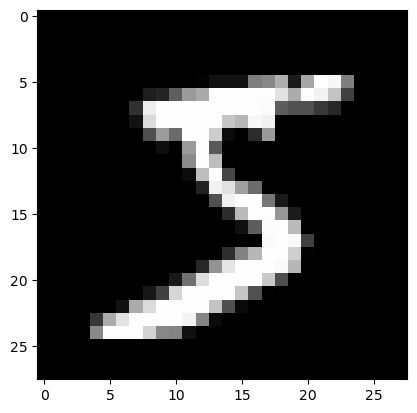

In [3]:
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')
print(train_dataset[0][1])

In [4]:
# Hyperparameters
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 256

# Optimization params
batch_size = 64
epochs_per_task = 10

# Reset optimizer after each age
reset_optimizer = True

## 2. Construct the model

In [5]:
task_output_space

{'1': 2, '2': 2, '3': 2, '4': 2, '5': 2}

In [6]:
agent_config_si = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': 1,
    'model_type': 'mlp',
    'model_name': 'MLP256_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_config = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': 0,
    'model_type': 'mlp',
    'model_name': 'MLP256_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_si = SI(agent_config_si)
agent = NormalNN(agent_config)

## 3. Trainig the model

### 3.1. SI

In [7]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table_si = OrderedDict()

agent_si.reset_optimizer = True

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table_si[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent_si.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table_si[val_name][train_name] = agent_si.validation(val_loader)

====================== 1 =======================
#reg_term: 0
Reset optimizer
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/198]	0.5261 (0.5261)	0.0150 (0.0150)	0.688 (0.688)	0.78 (0.78)
[100/198]	0.0180 (0.0238)	0.0090 (0.0105)	0.136 (0.049)	0.98 (0.99)
Train Acc: 0.996
Validation: Time: 0.354 Acc: 1.000
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0192 (0.0192)	0.0100 (0.0100)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0180 (0.0177)	0.0080 (0.0096)	0.000 (0.004)	1.00 (1.00)
Train Acc: 0.999
Validation: Time: 0.433 Acc: 0.998
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0199 (0.0199)	0.0098 (0.0098)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0223 (0.0197)	0.0101 (0.0089)	0.015 (0.004)	0.98 (1.00)
Train Acc: 0.999
Validation: Time: 0.380 Acc: 1.000
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0207 (0.0207)	0.0097 (0.0097)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0168 (0.0193)	0.0071 (0.0087)	0.004 (0.002)	1.00 (1.00)
Train Acc: 0.999
Validation: Time: 0.339 Acc: 0.999
Epoch: 4
Itr		Time

### 3.2. No regularization

In [8]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table = OrderedDict()

agent.reset_optimizer = True

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table[val_name][train_name] = agent.validation(val_loader)

====================== 1 =======================
Reset optimizer
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0260 (0.0260)	0.0150 (0.0150)	0.698 (0.698)	0.34 (0.34)
[100/198]	0.0169 (0.0170)	0.0099 (0.0095)	0.000 (0.043)	1.00 (0.99)
Train Acc: 0.994
Validation: Time: 0.370 Acc: 0.999
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0156 (0.0156)	0.0086 (0.0086)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0138 (0.0142)	0.0070 (0.0079)	0.000 (0.003)	1.00 (1.00)
Train Acc: 0.999
Validation: Time: 0.366 Acc: 0.999
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0154 (0.0154)	0.0081 (0.0081)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0147 (0.0161)	0.0077 (0.0088)	0.000 (0.000)	1.00 (1.00)
Train Acc: 0.999
Validation: Time: 0.373 Acc: 0.999
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/198]	0.0167 (0.0167)	0.0098 (0.0098)	0.000 (0.000)	1.00 (1.00)
[100/198]	0.0140 (0.0148)	0.0080 (0.0080)	0.001 (0.001)	1.00 (1.00)
Train Acc: 1.000
Validation: Time: 0.326 Acc: 1.000
Epoch: 4
Itr		Time		  Data		  L

### 3.3. Result

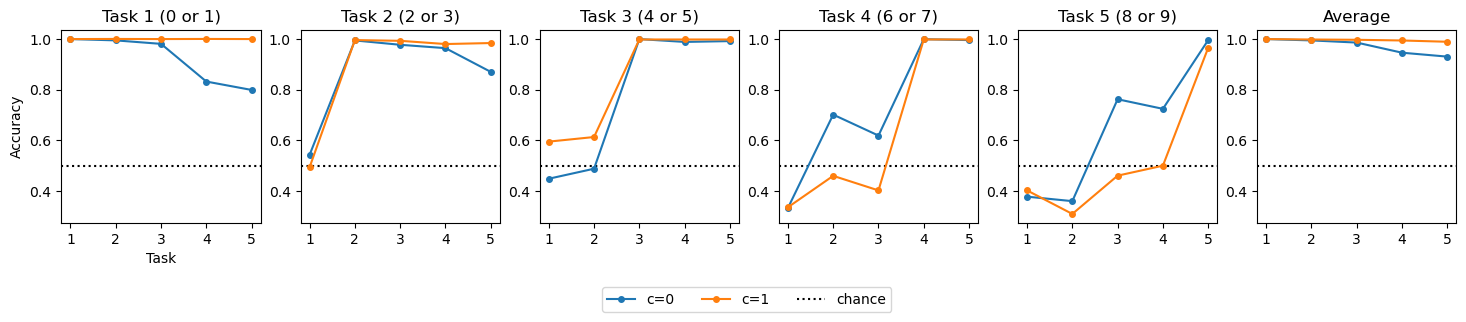

In [9]:
num_tasks = len(task_names)

# Add fig and axes
fig = plt.figure(figsize=(18, 2.5))
axs = [plt.subplot(1, num_tasks + 1, 1)]
for i in range(1, num_tasks + 1):
    axs.append(plt.subplot(1, num_tasks + 1, i + 1, sharey=axs[0], sharex=axs[0]))

# Plot accuracy for each task
for i in range(1, num_tasks + 1):
    axs[i - 1].plot(np.arange(1, num_tasks + 1), acc_table[str(i)].values(), '-o', label='c=0', lw=1.5, markersize=4)
    axs[i - 1].plot(np.arange(1, num_tasks + 1), acc_table_si[str(i)].values(), '-o', label='c=1', lw=1.5, markersize=4)

# Plot average accuracy
mean_acc = []
mean_acc_si = []
for i in range(1, num_tasks + 1):
    acc = 0
    acc_si = 0
    for j in range(1, i + 1):
        acc += acc_table[str(j)][str(i)]
        acc_si += acc_table_si[str(j)][str(i)]
    
    mean_acc.append(acc / i)
    mean_acc_si.append(acc_si / i)

axs[-1].plot(np.arange(1, num_tasks + 1), mean_acc, '-o', label='c=0', lw=1.5, markersize=4)
axs[-1].plot(np.arange(1, num_tasks + 1), mean_acc_si, '-o', label='c=1', lw=1.5, markersize=4)


# Add title and baseline
for i, ax in enumerate(axs):
    if i < num_tasks:
        ax.set_title(f'Task {i + 1} ({2*i} or {2*i + 1})')
    else:
        ax.set_title('Average')
    ax.axhline(0.5, color='k', linestyle=':', label="chance", zorder=0)

axs[-1].legend(loc='lower right', bbox_to_anchor=(-1.8, -.5),  ncol=3, frameon=True)

axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Task')
axs[0].set_xticks(np.arange(1, num_tasks + 1))

plt.show()